In [2]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [15]:
dataroot = "chest_xray/train"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
ngpu = 1

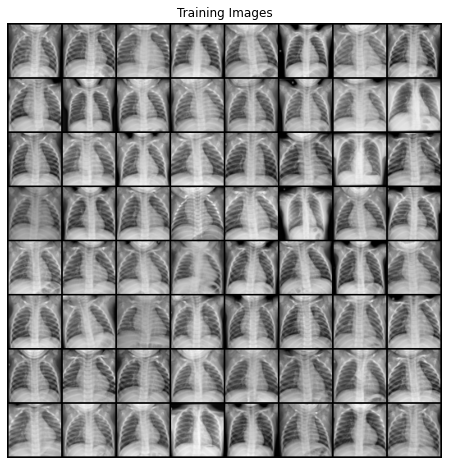

In [7]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [18]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator Code



In [19]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [20]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [21]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Starting Training Loop...
[0/100][0/11]	Loss_D: 0.6437	Loss_G: 6.1903	D(x): 0.8753	D(G(z)): 0.3626 / 0.0034


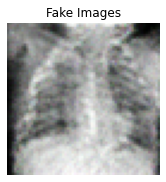

[1/100][0/11]	Loss_D: 3.5924	Loss_G: 5.9998	D(x): 0.0762	D(G(z)): 0.0001 / 0.0065
[2/100][0/11]	Loss_D: 0.4725	Loss_G: 3.5662	D(x): 0.8143	D(G(z)): 0.1864 / 0.0376
[3/100][0/11]	Loss_D: 0.7000	Loss_G: 3.0433	D(x): 0.6127	D(G(z)): 0.0560 / 0.0662
[4/100][0/11]	Loss_D: 0.5827	Loss_G: 2.7562	D(x): 0.6860	D(G(z)): 0.0985 / 0.0856
[5/100][0/11]	Loss_D: 1.8127	Loss_G: 4.1772	D(x): 0.2649	D(G(z)): 0.0026 / 0.0294
[6/100][0/11]	Loss_D: 0.3612	Loss_G: 2.5384	D(x): 0.8367	D(G(z)): 0.1249 / 0.1028
[7/100][0/11]	Loss_D: 0.5038	Loss_G: 4.8207	D(x): 0.8959	D(G(z)): 0.2993 / 0.0111
[8/100][0/11]	Loss_D: 0.7090	Loss_G: 2.2352	D(x): 0.5972	D(G(z)): 0.0758 / 0.1613
[9/100][0/11]	Loss_D: 0.8161	Loss_G: 7.8274	D(x): 0.9514	D(G(z)): 0.4929 / 0.0012
[10/100][0/11]	Loss_D: 0.5083	Loss_G: 5.5931	D(x): 0.9713	D(G(z)): 0.3402 / 0.0089
[11/100][0/11]	Loss_D: 0.5364	Loss_G: 5.5181	D(x): 0.9093	D(G(z)): 0.3187 / 0.0061
[12/100][0/11]	Loss_D: 1.1547	Loss_G: 10.2156	D(x): 0.9530	D(G(z)): 0.6104 / 0.0001
[13/100][0/1

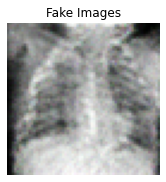

[46/100][0/11]	Loss_D: 0.4429	Loss_G: 2.6552	D(x): 0.7209	D(G(z)): 0.0514 / 0.0950
[47/100][0/11]	Loss_D: 1.1883	Loss_G: 10.7172	D(x): 0.9799	D(G(z)): 0.6391 / 0.0001
[48/100][0/11]	Loss_D: 0.6828	Loss_G: 2.5395	D(x): 0.6172	D(G(z)): 0.0360 / 0.0984
[49/100][0/11]	Loss_D: 0.4351	Loss_G: 4.8638	D(x): 0.9478	D(G(z)): 0.2924 / 0.0127
[50/100][0/11]	Loss_D: 0.3739	Loss_G: 6.1947	D(x): 0.9702	D(G(z)): 0.2609 / 0.0027
[51/100][0/11]	Loss_D: 0.2690	Loss_G: 3.9563	D(x): 0.8291	D(G(z)): 0.0537 / 0.0257
[52/100][0/11]	Loss_D: 0.3865	Loss_G: 4.1642	D(x): 0.7940	D(G(z)): 0.0666 / 0.0271
[53/100][0/11]	Loss_D: 0.2003	Loss_G: 4.2528	D(x): 0.8878	D(G(z)): 0.0637 / 0.0205
[54/100][0/11]	Loss_D: 0.3859	Loss_G: 3.3891	D(x): 0.7605	D(G(z)): 0.0434 / 0.0538
[55/100][0/11]	Loss_D: 0.5422	Loss_G: 7.7794	D(x): 0.6708	D(G(z)): 0.0026 / 0.0010
[56/100][0/11]	Loss_D: 0.4163	Loss_G: 3.8134	D(x): 0.8306	D(G(z)): 0.1708 / 0.0355
[57/100][0/11]	Loss_D: 0.4133	Loss_G: 3.4651	D(x): 0.8100	D(G(z)): 0.1434 / 0.0399
[58

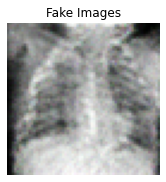

[91/100][0/11]	Loss_D: 0.6292	Loss_G: 5.5437	D(x): 0.6410	D(G(z)): 0.0030 / 0.0093
[92/100][0/11]	Loss_D: 0.3788	Loss_G: 4.4081	D(x): 0.7471	D(G(z)): 0.0136 / 0.0216
[93/100][0/11]	Loss_D: 0.2137	Loss_G: 4.4791	D(x): 0.9238	D(G(z)): 0.1111 / 0.0158
[94/100][0/11]	Loss_D: 0.4156	Loss_G: 7.7983	D(x): 0.9645	D(G(z)): 0.2816 / 0.0007
[95/100][0/11]	Loss_D: 0.4218	Loss_G: 7.4349	D(x): 0.9932	D(G(z)): 0.3094 / 0.0010
[96/100][0/11]	Loss_D: 0.2431	Loss_G: 5.9744	D(x): 0.9684	D(G(z)): 0.1703 / 0.0044
[97/100][0/11]	Loss_D: 1.0250	Loss_G: 10.6319	D(x): 0.9726	D(G(z)): 0.5476 / 0.0000
[98/100][0/11]	Loss_D: 0.2692	Loss_G: 4.8680	D(x): 0.8738	D(G(z)): 0.0990 / 0.0120
[99/100][0/11]	Loss_D: 0.7320	Loss_G: 2.6032	D(x): 0.5703	D(G(z)): 0.0074 / 0.1072


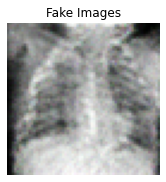

In [42]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
j=0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            plt.subplot(1,2,2)
            plt.axis("off")
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list2[-1],(1,2,0)))
            plt.show()
            
        iters += 1
    torch.save(netG.state_dict(), f"dcgan_trained_generator_{epoch}")

In [46]:
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load('dcgan_trained_generator_87'))

<All keys matched successfully>

In [47]:
img_list2=[]
fixed_noise = torch.randn(1, nz, 1, 1, device=device)
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    img_list2.append(vutils.make_grid(fake, padding=2, normalize=True))

In [62]:
import scipy.misc
import matplotlib.image as mpimg

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


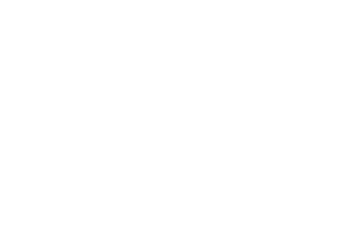

In [70]:
for i in range(30):
    img_list2=[]
    fixed_noise = torch.randn(1, nz, 1, 1, device=device)
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list2.append(vutils.make_grid(fake, padding=2, normalize=True))
#     plt.subplot(1,2,2)
    plt.axis("off")
#     plt.title("Fake Images")
    img = img_list2[-1]
    print(img.shape)
    from torchvision.utils import save_image
    save_image(img, f"dcgan_img_{i}.png")
#     break
#     plt.show()

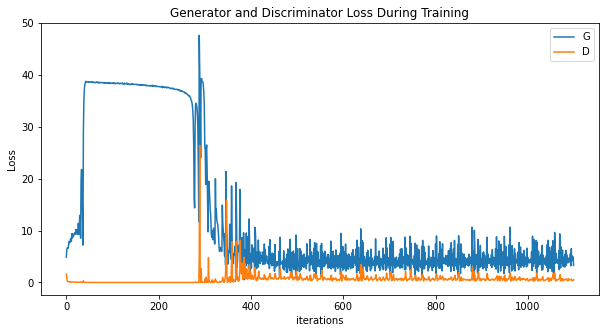

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

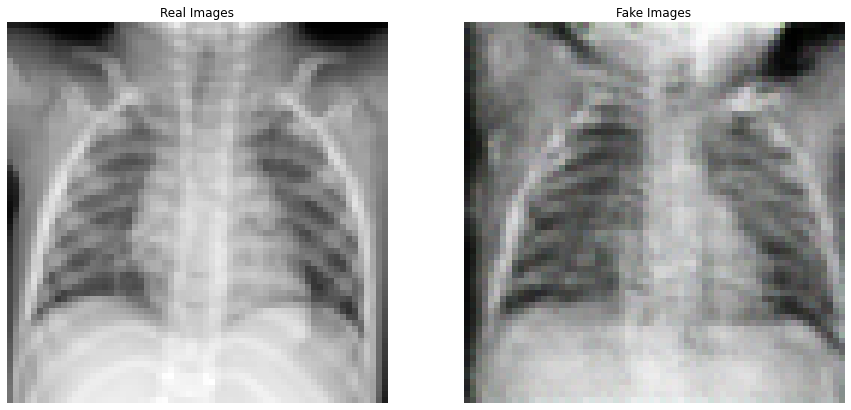

In [43]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()